In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import numba
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#importing the required ML packages
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn import linear_model

In [2]:
df_k = pd.read_csv("train_kanagawa.csv")
df_y= pd.read_csv("train_yamanashi.csv")

In [3]:
df_k['Clowdy'] = df_k['Weather'].map(lambda x: 1 if x == 1 else 0)
df_k['Rainy'] = df_k['Weather'].map(lambda x: 1 if x == 2 else 0)
df_k['Snowy'] = df_k['Weather'].map(lambda x: 1 if x == 3 else 0)
df_y['Clowdy'] = df_y['Weather'].map(lambda x: 1 if x == 1 else 0)
df_y['Rainy'] = df_y['Weather'].map(lambda x: 1 if x == 2 else 0)
df_y['Snowy'] = df_y['Weather'].map(lambda x: 1 if x == 3 else 0)

In [4]:
df_S1 = df_k.ix[:,['Solar1', 'Year', 'Date-No', 'Time', 'Rain', 'Temp', 'Clowdy', 'Rainy', 'Snowy']]
df_S2 = df_k.ix[:,['Solar2', 'Year', 'Date-No', 'Time', 'Rain', 'Temp', 'Clowdy', 'Rainy', 'Snowy']]
df_S3 = df_y.ix[:,['Solar3', 'Year', 'Date-No', 'Time', 'Rain', 'Temp', 'Clowdy', 'Rainy', 'Snowy']]

In [5]:
df_S3.head()

,Solar3,Year,Date-No,Time,Rain,Temp,Clowdy,Rainy,Snowy
0,NaN,2012,1,0.5,10.0,1,1,0,0
1,NaN,2012,1,1.0,10.0,1,1,0,0
2,NaN,2012,1,1.5,10.0,1,1,0,0
3,NaN,2012,1,2.0,10.0,1,1,0,0
4,NaN,2012,1,2.5,10.0,1,1,0,0


## これからやることリスト

### A. 説明変数の再設計
-A.1. Date-NoとTime→大気外日射量（extraterrestrial solar radiation：ex-SolarRadiation）へ（Refering Notton et al）<br>
-A.2. Windの追加（West-East-WindとSouth-North-Windへの分割は意味ある？？）<br>
-A.3. 前日の20時の積雪量を元にしたSnowの予測値（Pre-Snow）<br>
-A.4. 雲量を表すパラメータの追加（前日の同時刻での全天日射量/大気外日射量の追加or調べる時刻における全天日射量/大気外日射量の予測値の追加）<br>
-A.5. 各変数の正規化（Normalized-Temp）<br>

### B. 予測モデルの追加
-B.1. 既存のLassoに加えて、K-NNを実施する<br>
-B.2. K-NNのパラメータ調整（正規化、重みづけ最適化、変数過学習＆過多処理対策としての変数処理）<br>
-B.2. スコアの伸び率によって、三層パーセプトロンやSVRも検討する<br>

### A1 大気外日射量の計算

神奈川県浮島、扇島の緯度：35.5°N、139.75°Eを用いて、大気外日射量を計算する。

In [6]:
import math
from scipy import integrate

N = 35.5
E = 139.75

#Date-No, Timeから、その30分前から今までの大気外日射量を返す
def Culc(D, Time, N, E):
    
    Nantu_Time = 12 - 24 * (E - 135) / 361
    Sd0 = 1367
    d_d0 = 1 + 0.01676 * np.cos(0.01721*(D - 186))
    delta = 23.5 * np.cos(0.01689*(D - 173)) * math.pi / 180
    phi = math.pi * N / 180
    
    def f(t):
        omega = math.pi * (t - Nantu_Time) / 12
        Sh = Sd0 * (np.sin(phi)*np.sin(delta) + np.cos(phi)*np.cos(delta)*np.cos(omega)) / (d_d0**2)
        
        if Sh <= 0:
            Sh = 0
        return Sh
    
    S = integrate.quad(f, (Time - 0.5), Time)[0]
    
    #print('南中時刻：', Nantu_Time, '　f(t-0.5)：', f(Time-0.5), '　f(t)：', f(Time))
    
    return S

In [7]:
Culc(4,9, N, E)

224.6965451811633

＜発電所の緯度・経度＞<br>
浮島：北緯35度31分、東経139度47分15秒<br>
扇島：北緯35度29分20秒、東経139度43分40秒<br>
米倉山：北緯35度35分、東経138度34分30秒<br>


In [8]:
@numba.jit
def A(d,t, N, E):
    Ex_Solar = np.zeros(len(d))
    for i in tqdm(range(len(d))):
        Ex_Solar[i] = Culc(d[i],t[i], N ,E)
    return Ex_Solar

d = df_S1['Date-No']
t = df_S1['Time']
N = 35 + (31 / 60)
E = 139 + (47 / 60) + (15 / 3600)
df_S1['Ex-Solar'] = A(d,t, N, E)

d = df_S2['Date-No']
t = df_S2['Time']
N = 35 + (29 / 60) + (20 / 3600)
E = 139 + (43 / 60) + (40 / 3600)
df_S2['Ex-Solar'] = A(d,t, N, E)

d = df_S3['Date-No']
t = df_S3['Time']
N = 35 + (35 / 60)
E = 138 + (34 / 60) + (30 / 3600)
df_S3['Ex-Solar'] = A(d,t, N, E)

100%|██████████| 70128/70128 [00:22<00:00, 3050.31it/s]


In [9]:
df_S2[10:20]

,Solar2,Year,Date-No,Time,Rain,Temp,Clowdy,Rainy,Snowy,Ex-Solar
10,0.0,2012,1,5.5,30.0,4,1,0,0,0.000000
11,0.0,2012,1,6.0,30.0,4,1,0,0,0.000000
12,0.0,2012,1,6.5,30.0,4,1,0,0,0.000000
13,0.0,2012,1,7.0,30.0,4,1,0,0,2.925195
14,33.0,2012,1,7.5,30.0,4,1,0,0,51.728082
15,405.0,2012,1,8.0,30.0,4,1,0,0,113.393128
16,848.0,2012,1,8.5,30.0,4,1,0,0,170.391439
17,1046.0,2012,1,9.0,30.0,4,1,0,0,221.747758
18,1521.0,2012,1,9.5,30.0,6,1,0,0,266.583363
19,1608.0,2012,1,10.0,30.0,6,1,0,0,304.131107


### A2 風の追加

In [10]:
from filer3 import Filer

data = Filer.read_tsv('data/forecast_kanagawa.tsv')
df_fk = pd.DataFrame(data[1:], columns = data[0])
data = Filer.read_tsv('data/forecast_yamanashi.tsv')
df_fy = pd.DataFrame(data[1:], columns = data[0])

In [11]:
df_fk['Year'] = df_fk['date'].map(lambda x : x[0:4])
df_fk['Month'] = df_fk['date'].map(lambda x : x[5:7])
df_fk['Date'] = df_fk['date'].map(lambda x : x[8:10])
df_fy['Year'] = df_fy['date'].map(lambda x : x[0:4])
df_fy['Month'] = df_fy['date'].map(lambda x : x[5:7])
df_fy['Date'] = df_fy['date'].map(lambda x : x[8:10])

In [12]:
df_fk = df_fk.drop(['date', 'weather', 'weather_detail', 'wind', 'min_tp', 'max_tp'], axis=1)
df_fy = df_fy.drop(['date', 'weather', 'weather_detail', 'wind', 'min_tp', 'max_tp'], axis=1)

In [13]:
df_fy['Year'] = df_fy['Year'].map(lambda x: int(x))
df_fy['Month'] = df_fy['Month'].map(lambda x: int(x))
df_fy['Date'] = df_fy['Date'].map(lambda x: int(x))

df_fk['Year'] = df_fk['Year'].map(lambda x: int(x))
df_fk['Month'] = df_fk['Month'].map(lambda x: int(x))
df_fk['Date'] = df_fk['Date'].map(lambda x: int(x))

In [14]:
def MtoD(x, y):
    
    r = 0
    if x >= 2:
        r = r + 31
        
        if x >= 3:
            if y%4 == 0:
                r = r + 29
            else:
                r = r + 28
            
            if x >= 4:
                r = r + 31
                if x >= 5:
                    r = r + 30
                    if x >= 6:
                        r = r + 31
                        if x >= 7:
                            r = r + 30
                            if x >= 8:
                                r = r + 31
                                if x >= 9:
                                    r = r + 31
                                    if x >= 10:
                                        r = r + 30
                                        if x >= 11:
                                            r = r + 31
                                            if x == 12:
                                                r = r + 30
    return r

In [15]:
dfs = [df_fy, df_fk]

for df in dfs:

    df['Date-No'] = 0

    M = df['Month']
    D = df['Date']
    Y = df['Year']

    @numba.jit
    def Make_DateNo(M,D,Y):
        Date_No = np.zeros(len(D))
        for i in tqdm(range(len(D))):
            Date_No[i] = MtoD(M[i],Y[i]) + D[i]
        return Date_No


    df['Date-No'] = Make_DateNo(M,D,Y)
    df['Date-No'] = df['Date-No'].map(lambda x: int(x))

100%|██████████| 1917/1917 [00:00<00:00, 23034.47it/s]


In [16]:
df_fk = df_fk.drop(["Month", "Date"], axis=1)
df_fy = df_fy.drop(["Month", "Date"], axis=1)

In [17]:
df_S1 = pd.merge(df_S1, df_fk, on=['Year', 'Date-No'])
df_S2 = pd.merge(df_S2, df_fk, on=['Year', 'Date-No'])
df_S3 = pd.merge(df_S3, df_fy, on=['Year', 'Date-No'])

In [18]:
dfs = [df_S1, df_S2, df_S3]
lis = ['wc_00-03', 'wc_03-06', 'wc_06-09', 'wc_09-12', 'wc_12-15', 'wc_15-18', 'wc_18-21', 'wc_21-24']


for df in dfs:
    df['Wind'] = 0
    
    df.loc[df['Time'] <=24 , 'Wind'] = df[lis[7]]
    df.loc[df['Time'] <=21 , 'Wind'] = df[lis[6]]
    df.loc[df['Time'] <=18 , 'Wind'] = df[lis[5]]
    df.loc[df['Time'] <=15 , 'Wind'] = df[lis[4]]
    df.loc[df['Time'] <=12 , 'Wind'] = df[lis[3]]
    df.loc[df['Time'] <=9 , 'Wind'] = df[lis[2]]
    df.loc[df['Time'] <=6 , 'Wind'] = df[lis[1]]
    df.loc[df['Time'] <=3 , 'Wind'] = df[lis[0]]

In [19]:
df_S1 = df_S1.ix[:,['Solar1', 'Year', 'Date-No', 'Time', 'Ex-Solar', 'Rain', 'Temp',  'Wind','Clowdy', 'Rainy', 'Snowy']]
df_S2 = df_S2.ix[:,['Solar2', 'Year', 'Date-No', 'Time', 'Ex-Solar', 'Rain', 'Temp',  'Wind','Clowdy', 'Rainy', 'Snowy']]
df_S3 = df_S3.ix[:,['Solar3', 'Year', 'Date-No', 'Time', 'Ex-Solar', 'Rain', 'Temp',  'Wind','Clowdy', 'Rainy', 'Snowy']]

In [20]:
df_S3.head()

,Solar3,Year,Date-No,Time,Ex-Solar,Rain,Temp,Wind,Clowdy,Rainy,Snowy
0,NaN,2012,1,0.5,0.0,10.0,1,2,1,0,0
1,NaN,2012,1,1.0,0.0,10.0,1,2,1,0,0
2,NaN,2012,1,1.5,0.0,10.0,1,2,1,0,0
3,NaN,2012,1,2.0,0.0,10.0,1,2,1,0,0
4,NaN,2012,1,2.5,0.0,10.0,1,2,1,0,0


### A3 積雪量の予測値（Pre-Snow）の追加

まずはSolar1,2について、横浜観測所と日吉観測所のデータを加える

In [21]:
from filer3 import Filer

yoko = Filer.read_tsv('data/amd_46106_yokohama.tsv')
df_yoko= pd.DataFrame(yoko[1:], columns = yoko[0])
hiyoshi = Filer.read_tsv('data/amd_46061_hiyoshi.tsv')
df_hiyoshi = pd.DataFrame(hiyoshi[1:], columns = hiyoshi[0])

In [22]:
yoko = Filer.read_tsv('data/sfc_47670_yokohama.tsv')
df_dy= pd.DataFrame(yoko[1:], columns = yoko[0])

積雪量の観測数

In [23]:
pd.crosstab(df_yoko.sd, df_yoko.f_sd).T.style.background_gradient(cmap='summer_r')

In [24]:
pd.crosstab(df_hiyoshi.sd, df_hiyoshi.f_sd).T.style.background_gradient(cmap='summer_r')

In [25]:
pd.crosstab(df_dy.sd, df_dy.f_sd).T.style.background_gradient(cmap='summer_r')

df_yokoとdf_dyは内容が同じ。一方hiyoshiは積雪量を観測していない。よってdf_yokoを見ていく。

In [26]:
df_yoko['Year'] = df_yoko['datetime'].map(lambda x : x[0:4])
df_yoko['Month'] = df_yoko['datetime'].map(lambda x : x[4:6])
df_yoko['Date'] = df_yoko['datetime'].map(lambda x : x[6:8])
df_yoko['Time'] = df_yoko['datetime'].map(lambda x : x[8:12])

df_yoko['Year'] = df_yoko['Year'].map(lambda x: int(x))
df_yoko['Month'] = df_yoko['Month'].map(lambda x: int(x))
df_yoko['Date'] = df_yoko['Date'].map(lambda x: int(x))

@numba.jit
def C(T):
    ans = np.empty(len(T))
    for i in tqdm(range(len(T))):
        x = T[i]
        if x[2:4] == "00":
            ans[i] = float(x[0:2])
        elif x[2:4] == "10":
            ans[i] = float(x[0:2]) + (1 / 6)
        elif x[2:4] == "20":
            ans[i] = float(x[0:2]) + (2 / 6)
        elif x[2:4] == "30":
            ans[i] = float(x[0:2]) + (3 / 6)
        elif x[2:4] == "40":
            ans[i] = float(x[0:2]) + (4 / 6)
        else:
            ans[i] = float(x[0:2]) + (5 / 6)
    return ans

df_yoko['Time'] = C(df_yoko['Time'])
df_yoko['Time'] = df_yoko['Time'].map(lambda x: round(x,1))

M = df_yoko['Month']
D = df_yoko['Date']
Y = df_yoko['Year']
df_yoko['Date-No'] = Make_DateNo(M,D,Y)
df_yoko['Date-No'] = df_yoko['Date-No'].map(lambda x: int(x))

df_yoko = df_yoko.ix[:,['Year', 'Date-No', 'Time','f_sd', 'sd', 'f_dsd','dsd']]

100%|██████████| 276048/276048 [00:11<00:00, 23177.52it/s]


##### 測定されていない期間はどのような期間かを確認する

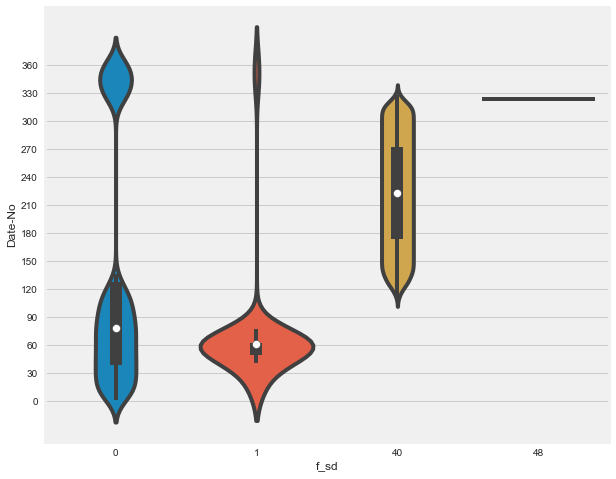

In [27]:
f, ax = plt.subplots(1,1,figsize=(9,8))
sns.violinplot("f_sd","Date-No", data=df_yoko ,split=True,ax=ax)
ax.set_yticks(range(0,366,30))
plt.show()

・冬季以外を測定していない！よって、sd=""は0に置き換えて問題ない。

In [28]:
df_yoko['sd'] = df_yoko['sd'].map(lambda x: 0 if x == "" else x)
df_yoko['sd'] = df_yoko['sd'].map(lambda x: int(x))

In [29]:
df_yoko['dsd'] = df_yoko['dsd'].map(lambda x: 0 if x == "" else x)
df_yoko['dsd'] = df_yoko['dsd'].map(lambda x: int(x))

前日20時までのデータから翌日の0~20時のPre-Snowを予測しましょう

In [30]:
df_presnow = pd.merge(df_S1, df_yoko, on=['Year', 'Date-No', 'Time'])
df_presnow['Snow'] = df_presnow['sd']

In [31]:
@numba.jit
def Take_20(Time, Snow):
    answer = np.empty(len(Time))
    for i in tqdm(range(len(Time))):
        if Time[i] >= 20:
            index = i - 2*(Time[i] - 20)
        else:
            index = i - 2*Time[i] - 8
        if index < 0:
            index = 0
        answer[i] = Snow[index]
    return answer

In [32]:
df_presnow['20'] = Take_20(df_presnow['Time'], df_presnow['Snow'])

100%|██████████| 70128/70128 [00:03<00:00, 22566.04it/s]


In [33]:
df_presnow['Change-Snow'] = df_presnow['dsd']
df_presnow['20-Change'] = Take_20(df_presnow['Time'], df_presnow['Change-Snow'])

100%|██████████| 70128/70128 [00:02<00:00, 26143.44it/s]


In [34]:
df_presnow['Time-from-20'] = 0
df_presnow.loc[df_presnow['Time'] < 20, 'Time-from-20'] = 4 + df_presnow[df_presnow['Time'] < 20]['Time']
df_presnow.loc[df_presnow['Time'] > 20, 'Time-from-20'] = df_presnow[df_presnow['Time'] > 20]['Time'] - 20

In [35]:
df_presnow = df_presnow.ix[:,['Snow', '20', 'Time-from-20', '20-Change','Temp', 'Ex-Solar', 'Rain', 'Clowdy', 'Rainy', 'Snowy']]
df = df_presnow

In [36]:
df.head()

,Snow,20,Time-from-20,20-Change,Temp,Ex-Solar,Rain,Clowdy,Rainy,Snowy
0,0,0.0,4.5,0.0,5,0.0,30.0,1,0,0
1,0,0.0,5.0,0.0,5,0.0,30.0,1,0,0
2,0,0.0,5.5,0.0,5,0.0,30.0,1,0,0
3,0,0.0,6.0,0.0,5,0.0,30.0,1,0,0
4,0,0.0,6.5,0.0,5,0.0,30.0,1,0,0


In [37]:
pd.crosstab(df['Snow'], df['20']).T.style.background_gradient(cmap='summer_r')

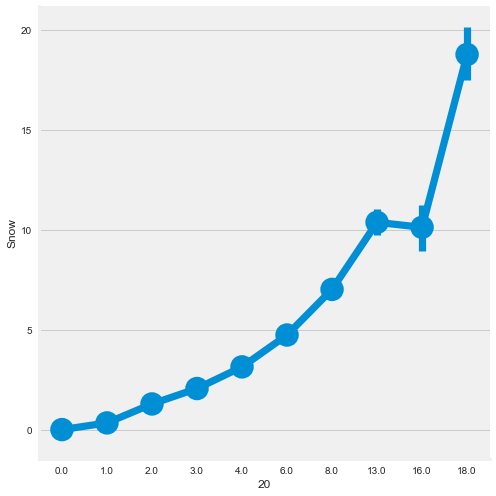

In [38]:
sns.factorplot('20', 'Snow', data=df,size = 7)

In [39]:
df['20*2'] = df['20'] * 2
df['Snow-20'] = df['Snow'] - df['20']
df = df.ix[:,['Snow-20', '20', '20*2','Time-from-20', '20-Change', 'Temp', 'Rain', 'Clowdy', 'Snowy']]

In [40]:
df.head()

,Snow-20,20,20*2,Time-from-20,20-Change,Temp,Rain,Clowdy,Snowy
0,0.0,0.0,0.0,4.5,0.0,5,30.0,1,0
1,0.0,0.0,0.0,5.0,0.0,5,30.0,1,0
2,0.0,0.0,0.0,5.5,0.0,5,30.0,1,0
3,0.0,0.0,0.0,6.0,0.0,5,30.0,1,0
4,0.0,0.0,0.0,6.5,0.0,5,30.0,1,0


In [41]:
df_ = df[df['20'] == 0]
df = df[df['20'] != 0]

In [42]:
#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Snow-20']

    #Lasso回帰
    clf_lasso = linear_model.Lasso(alpha=1.0)
    clf_lasso.fit(train_X, train_Y)

    train_Y['Predicted'] = clf_lasso.predict(train_X.as_matrix())
    train_Y['Predicted'] = train_Y['Predicted'].map(lambda x: int(x - 0.2))
    train_Y['Error_abs'] = np.abs(train_Y['Snow-20'] - train_Y['Predicted'])

    test_Y['Predicted'] = clf_lasso.predict(test_X.as_matrix())
    test_Y['Predicted'] = test_Y['Predicted'].map(lambda x: int(x - 0.2))
    test_Y['Error_abs'] = np.abs(test_Y['Snow-20'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 1.06043360434
MAE_test: 1.10125786164


In [43]:
np.abs(df['Snow-20']).mean()

1.7840909090909092

In [44]:
#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Snow-20']

    # 必要なライブラリのインポート
    from sklearn.ensemble import RandomForestRegressor
    # モデル構築、パラメータはデフォルト
    forest = RandomForestRegressor()
    forest.fit(train_X, train_Y)
    
    #予測
    train_Y['Predicted'] = forest.predict(train_X)
    train_Y['Error_abs'] = np.abs(train_Y['Snow-20'] - train_Y['Predicted'])
    test_Y['Predicted']= forest.predict(test_X)
    test_Y['Error_abs'] = np.abs(test_Y['Snow-20'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 0.0974254742547
MAE_test: 0.270440251572


・そのまま前日の20時を使うより回帰して使った方が良い。RFは良い感じ。

これを実践する

In [45]:
forest = RandomForestRegressor()
forest.fit(df[df.columns[1:]], df[df.columns[:1]])
df['Pre-Snow'] = forest.predict(df[df.columns[1:]]) + df['20']
df_['Pre-Snow'] = 0

In [46]:
df = pd.concat([df,df_], axis=0)
df = df.sort_index()

In [47]:
df_S1['Pre-Snow'] = df['Pre-Snow']
df_S2['Pre-Snow'] = df['Pre-Snow']

In [48]:
df_S2.head()

,Solar2,Year,Date-No,Time,Ex-Solar,Rain,Temp,Wind,Clowdy,Rainy,Snowy,Pre-Snow
0,0.0,2012,1,0.5,0.0,30.0,5,2,1,0,0,0.0
1,0.0,2012,1,1.0,0.0,30.0,5,2,1,0,0,0.0
2,0.0,2012,1,1.5,0.0,30.0,5,2,1,0,0,0.0
3,0.0,2012,1,2.0,0.0,30.0,5,2,1,0,0,0.0
4,0.0,2012,1,2.5,0.0,30.0,5,2,1,0,0,0.0


###### 同様に山梨（甲府）についてPre-Snowを成形

In [49]:
kofu = Filer.read_tsv('data/amd_49142_kofu.tsv')
df_kofu= pd.DataFrame(kofu[1:], columns = kofu[0])

In [50]:
df_yoko = df_kofu

df_yoko['Year'] = df_yoko['datetime'].map(lambda x : x[0:4])
df_yoko['Month'] = df_yoko['datetime'].map(lambda x : x[4:6])
df_yoko['Date'] = df_yoko['datetime'].map(lambda x : x[6:8])
df_yoko['Time'] = df_yoko['datetime'].map(lambda x : x[8:12])

df_yoko['Year'] = df_yoko['Year'].map(lambda x: int(x))
df_yoko['Month'] = df_yoko['Month'].map(lambda x: int(x))
df_yoko['Date'] = df_yoko['Date'].map(lambda x: int(x))

df_yoko['Time'] = C(df_yoko['Time'])
df_yoko['Time'] = df_yoko['Time'].map(lambda x: round(x,1))

M = df_yoko['Month']
D = df_yoko['Date']
Y = df_yoko['Year']
df_yoko['Date-No'] = Make_DateNo(M,D,Y)
df_yoko['Date-No'] = df_yoko['Date-No'].map(lambda x: int(x))

df_yoko = df_yoko.ix[:,['Year', 'Date-No', 'Time','f_sd', 'sd', 'f_dsd','dsd']]

100%|██████████| 276048/276048 [00:11<00:00, 23948.10it/s]


In [51]:
df_yoko['sd'] = df_yoko['sd'].map(lambda x: 0 if x == "" else x)
df_yoko['sd'] = df_yoko['sd'].map(lambda x: int(x))
df_yoko['dsd'] = df_yoko['dsd'].map(lambda x: 0 if x == "" else x)
df_yoko['dsd'] = df_yoko['dsd'].map(lambda x: int(x))

In [52]:
df_presnow = pd.merge(df_S3, df_yoko, on=['Year', 'Date-No', 'Time'])
df_presnow['Snow'] = df_presnow['sd']

In [53]:
df_presnow['20'] = Take_20(df_presnow['Time'], df_presnow['Snow'])
df_presnow['Change-Snow'] = df_presnow['dsd']
df_presnow['20-Change'] = Take_20(df_presnow['Time'], df_presnow['Change-Snow'])
df_presnow['Time-from-20'] = 0
df_presnow.loc[df_presnow['Time'] < 20, 'Time-from-20'] = 4 + df_presnow[df_presnow['Time'] < 20]['Time']
df_presnow.loc[df_presnow['Time'] > 20, 'Time-from-20'] = df_presnow[df_presnow['Time'] > 20]['Time'] - 20
df_presnow = df_presnow.ix[:,['Snow', '20', 'Time-from-20', '20-Change', 'Temp', 'Ex-Solar', 'Rain', 'Clowdy', 'Rainy', 'Snowy']]
df = df_presnow

100%|██████████| 70128/70128 [00:02<00:00, 24260.63it/s]


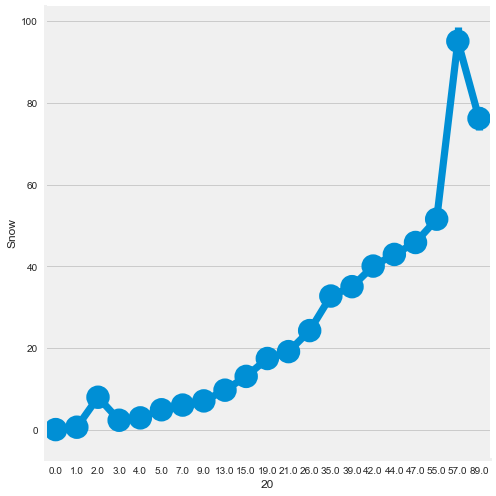

In [54]:
sns.factorplot('20', 'Snow', data=df,size = 7)

In [55]:
df['20*2'] = df['20'] * 2
df['Snow-20'] = df['Snow'] - df['20']
df = df.ix[:,['Snow-20', '20', '20*2', '20-Change', 'Time-from-20', 'Temp', 'Rain', 'Clowdy', 'Snowy']]

In [56]:
df_ = df[df['20'] == 0]
df = df[df['20'] != 0]

In [57]:
#train, testを分けて（10回やって、その平均をスコアとする）
MAE_train = []
MAE_test = []
for i in range(10):
    train,test=train_test_split(df,test_size=0.3,random_state=i)
    train_X=train[train.columns[1:]]
    train_Y=train[train.columns[:1]]
    test_X=test[test.columns[1:]]
    test_Y=test[test.columns[:1]]
    X=df[df.columns[1:]]
    Y=df['Snow-20']

    # 必要なライブラリのインポート
    from sklearn.ensemble import RandomForestRegressor
    # モデル構築、パラメータはデフォルト
    forest = RandomForestRegressor()
    forest.fit(train_X, train_Y)
    
    #予測
    train_Y['Predicted'] = forest.predict(train_X)
    train_Y['Error_abs'] = np.abs(train_Y['Snow-20'] - train_Y['Predicted'])
    test_Y['Predicted']= forest.predict(test_X)
    test_Y['Error_abs'] = np.abs(test_Y['Snow-20'] - test_Y['Predicted'])

    MAE_train.append(train_Y['Error_abs'].mean())
    MAE_test.append(test_Y['Error_abs'].mean())

print("MAE_train:", np.mean(np.array(MAE_train)))
print("MAE_test:", np.mean(np.array(MAE_test)))

MAE_train: 0.137497091034
MAE_test: 0.360683014354


In [58]:
np.abs(df['Snow-20']).mean()

3.5208333333333335

In [59]:
forest = RandomForestRegressor()
forest.fit(df[df.columns[1:]], df[df.columns[:1]])
df['Pre-Snow'] = forest.predict(df[df.columns[1:]]) + df['20']
df_['Pre-Snow'] = 0
df = pd.concat([df,df_], axis=0)
df = df.sort_index()
df_S3['Pre-Snow'] = df['Pre-Snow']

In [60]:
df_S3.head()

,Solar3,Year,Date-No,Time,Ex-Solar,Rain,Temp,Wind,Clowdy,Rainy,Snowy,Pre-Snow
0,NaN,2012,1,0.5,0.0,10.0,1,2,1,0,0,0.0
1,NaN,2012,1,1.0,0.0,10.0,1,2,1,0,0,0.0
2,NaN,2012,1,1.5,0.0,10.0,1,2,1,0,0,0.0
3,NaN,2012,1,2.0,0.0,10.0,1,2,1,0,0,0.0
4,NaN,2012,1,2.5,0.0,10.0,1,2,1,0,0,0.0


問題点：前日の20時で積雪がなければ、積雪しないものと予測してしまっている。加えて予測も単純なRFであり、精査がまた改めて必要。

##### A* 相関

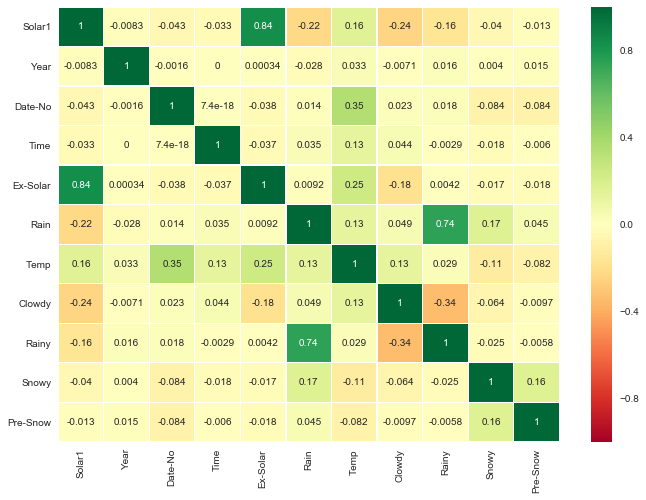

In [61]:
sns.heatmap(df_S1.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

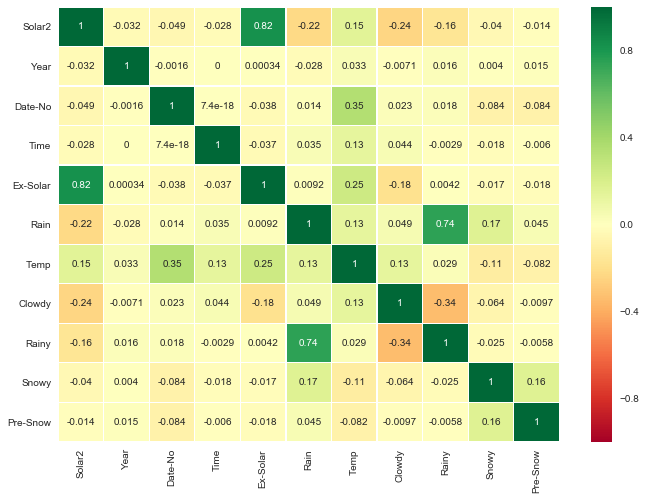

In [62]:
sns.heatmap(df_S2.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

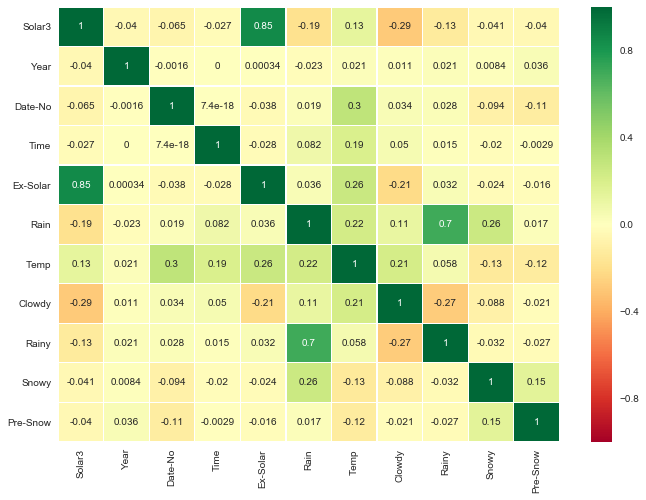

In [63]:
sns.heatmap(df_S3.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

##### 一旦保存する

In [64]:
df_S1.to_csv('train_S1.csv', index = False,  header = True)
df_S2.to_csv('train_S2.csv', index = False,  header = True)
df_S3.to_csv('train_S3.csv', index = False,  header = True)